In [172]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.show()
plt.close()
matplotlib.rcParams.update({"font.size": 16})

<Figure size 432x288 with 0 Axes>

In [173]:
import numpy as np
import os
import copy
import datetime
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

# gpr fitting
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, RationalQuadratic, Matern, DotProduct

# i tried joblib and dill to save the model but they didn't work
# because under the hood i used a sympy lambdify function
# this SO post solved my issue using cloudpickle.
# https://stackoverflow.com/a/31365136/12840171
import cloudpickle

In [174]:
import sys
sys.path.append('../scratch_2_mod')

In [175]:
# custom
import phenom
import workflow_utils
import pn

import collocation

In [176]:
import sympy
# sympy.init_printing()
# x_sym, a_sym, om_rd = sympy.symbols('x_sym a_sym om_rd')

# x_sym: generic name I use for independent variables for sympy
x_sym = sympy.symbols('x_sym')

# Config

In [177]:
target = 'freq'
# region = 'inspiral'

# tag = datetime.date.today().strftime("%d_%m_%y")

# ROOT_DIR = "/Users/sebastian.khan/personal/data/gpm_model"
# OUTPUT_DIR = f"{target}_{region}_{tag}"
# OUTPUT_PATH = os.path.join(ROOT_DIR, OUTPUT_DIR)

# print(f"{OUTPUT_DIR = }")
# print(f"{OUTPUT_PATH = }")

In [178]:
# os.makedirs(OUTPUT_PATH, exist_ok=False)

In [179]:
# TaylorT3 PN parameters
tc=0 # doesn't work so well for high q
# tc=100 # reasonable compromise
# tc=1000 # doesn't recover T3 for early times
M=1

# Time range avaiable to use for fitting and testing
pad = 10
t_start = -700 - pad
t_end = -100 + pad

# can choose to resample or not
# dt = 0.1
dt = None

## DEFINE ANSATZ

base_ansatz = np.sum([x_sym**8, x_sym**9, x_sym**10])
# base_ansatz = np.sum([x_sym**8, x_sym**9, x_sym**10, x_sym**11])
# base_ansatz = np.sum([x_sym**8, x_sym**9, x_sym**10, x_sym**11, x_sym**12])
collocation_points = {
    # 0:[-700, -500, -300],
    0:[-700, -300, -100],
    # 0:[-700, -500, -200],
    # 0:[-700, -500, -300, -200],
    # 0:[-700, -300, -200, -100],
    # 1:[-300, -100],
}

# Load NR

In [180]:
data_dict = workflow_utils.load_nr_data()

# test_set_query='(q>1 and q<2) or (q>2 and q<=4) or (q>=7 and q<10) or (q>=14 and q<16)'
# data_dict = workflow_utils.load_nr_data(test_set_query=test_set_query)



In [181]:
data_dict['train_idxs']

Int64Index([ 0,  4,  6,  8, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26,
            27, 31, 35, 37, 38, 46, 51, 53],
           dtype='int64')

In [182]:
data_dict['test_idxs']

Int64Index([ 1,  2,  3,  5,  7,  9, 11, 14, 24, 25, 28, 29, 30, 32, 33, 34, 36,
            39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 52],
           dtype='int64')

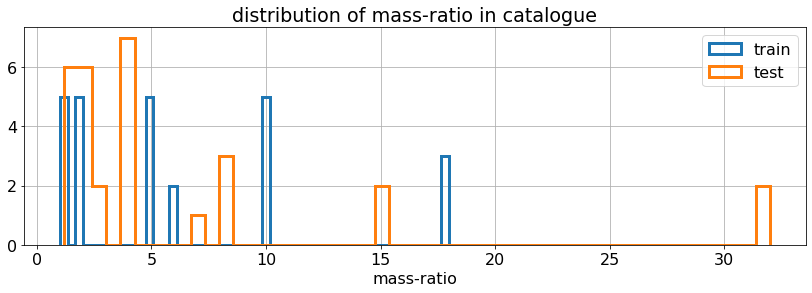

In [183]:
plt.figure(figsize=(14, 4))
plt.hist(data_dict['df']['q'][data_dict['train_idxs']], bins=50, histtype='step', lw=3, label='train')
plt.hist(data_dict['df']['q'][data_dict['test_idxs']], bins=50, histtype='step', lw=3, label='test')
plt.legend()
plt.xlabel("mass-ratio");
plt.title("distribution of mass-ratio in catalogue")
plt.grid()

In [184]:
waveforms = [
    workflow_utils.Waveform(
        strain=data_dict['strains'][i],
        times=data_dict['times'],
        amp=data_dict['amps'][i],
        phase=data_dict['phases'][i],
        freq=data_dict['freqs'][i],
        q=data_dict['df']['q'].values[i],
        meta_data=data_dict['df'].loc[[i]],
    )
    for i in range(len(data_dict['df']))]

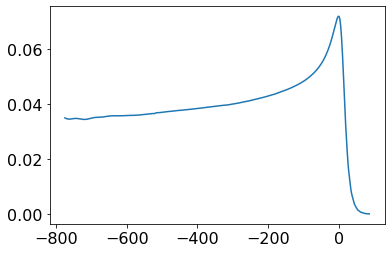

In [185]:
plt.plot(waveforms[0].times, waveforms[0].amp)

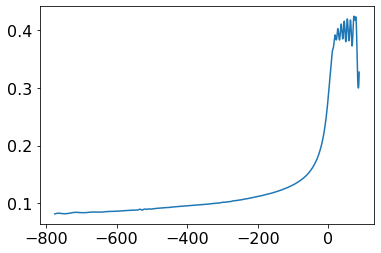

In [186]:
plt.plot(waveforms[0].times, waveforms[0].freq)

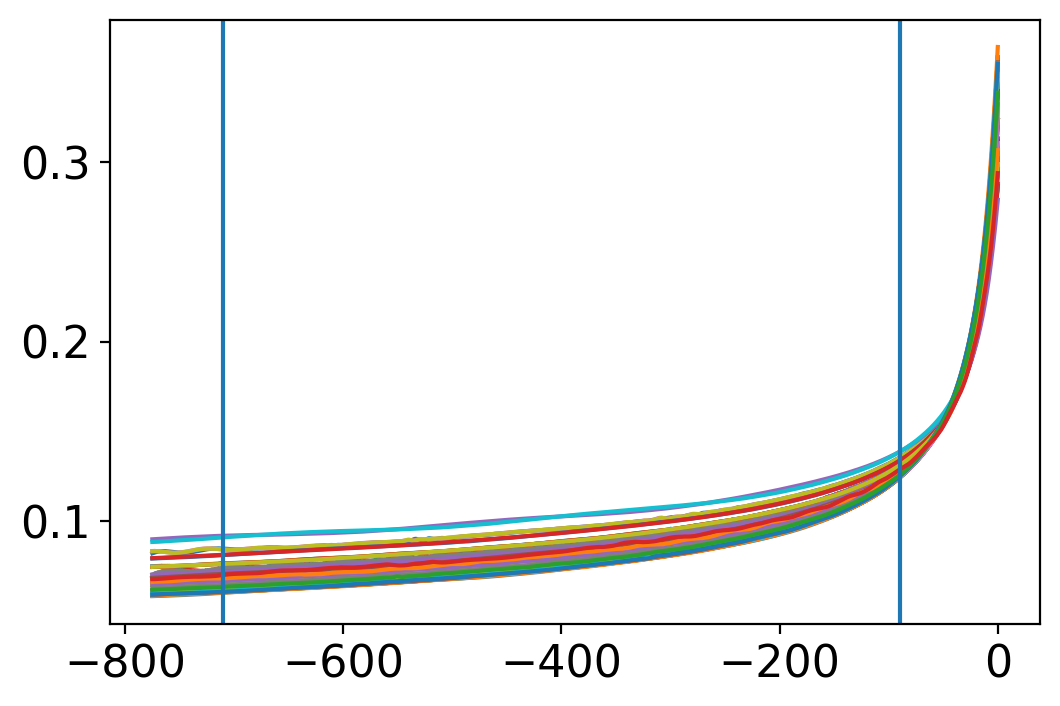

In [187]:
plt.figure(dpi=200)
for waveform in waveforms:
    mask = waveform.times < 0
    plt.plot(waveform.times[mask], waveform.freq[mask])
plt.axvline(t_start)
plt.axvline(t_end)

In [188]:

# wcfs: Waveform Collocation Fitter objects
wcfs = []
# list of TaylorT3 Newtonian term for each sample
omega_Ns = []
# list of TaylorT3 full PN for each sample
omega_pns = []


for i in range(len(data_dict['df'])):
    q = data_dict['df'].iloc[i]['q']
    name = data_dict['df'].iloc[i]['name']
    set_member = data_dict['df'].iloc[i]['set']
    print(f"working: {i} ({set_member}): q={q} \t {name}")
    
    eta = phenom.eta_from_q(q)
    
    # get data to fit
    t_, y_ = workflow_utils.prepare_fit_data(
        waveform=waveforms[i],
        t_start=t_start,
        t_end=t_end,
        target=target,
        dt=dt,
    )
    
    # PN parameters
    pn_kwargs=dict(t=t_, tc=tc, eta=eta, M=M)

    # Get PN transformation variables
    omega_N, omega_pn = workflow_utils.get_taylort3_inspiral_omega_affine_params(t_, tc, eta, M)
    
    # apply tranformation
    y_transformed = workflow_utils.transformation_affine_reverse(y_, omega_N, omega_pn)
    
    # prepare ansatz
    theta = pn.TaylorT3_theta(x_sym, tc, eta, M)
    pn_sub_dict = {'x_sym': theta }
    ansatz = base_ansatz.subs(pn_sub_dict)
    sub_dict={}
    
    wcf = workflow_utils.WaveformCollocationFitter(
        t_,
        y_transformed,
        collocation_points,
        ansatz,
        sub_dict,
    )

    omega_Ns.append(omega_N)
    omega_pns.append(omega_pn)
    wcfs.append(wcf)

working: 0 (train): q=18.0 	 q18a0a0c025_96_fine
working: 1 (test): q=4.0 	 q4a0_T_96_384
working: 2 (test): q=8.0 	 q8a0a0_T_96_504n512
working: 3 (test): q=8.0 	 q8a0a0c05_T_80_420
working: 4 (train): q=10.0 	 q10c25e_T_112_448
working: 5 (test): q=4.0 	 q4a0_T_80_320
working: 6 (train): q=18.0 	 q18a0a0c025_144
working: 7 (test): q=8.0 	 q8a0a0_T_112_588n768
working: 8 (train): q=18.0 	 q18a0a0c025_120
working: 9 (test): q=4.0 	 q4a0_T_112_448
working: 10 (train): q=5.0 	 SXS_BBH_0107_Res3
working: 11 (test): q=4.0 	 SXS_BBH_0167_Res5
working: 12 (train): q=5.0 	 SXS_BBH_0107_Res5
working: 13 (train): q=5.0 	 SXS_BBH_0107_Res4
working: 14 (test): q=4.0 	 SXS_BBH_0167_Res3
working: 15 (train): q=2.0 	 SXS_BBH_0169_Res4
working: 16 (train): q=2.0 	 SXS_BBH_0169_Res5
working: 17 (train): q=2.0 	 SXS_BBH_0169_Res3
working: 18 (train): q=1.0 	 SXS_BBH_0180_Res3
working: 19 (train): q=10.0 	 SXS_BBH_0303_Res3
working: 20 (train): q=1.0 	 SXS_BBH_0180_Res2
working: 21 (train): q=10.0 	 SXS

In [189]:
titles_ = []
y0s_ = []
y1s_ = []
pns_ = []
for i in range(len(data_dict['df'])):
    title_ = data_dict['df']['tag'][i]
    y0_ = workflow_utils.transformation_affine_foward(wcfs[i].y, omega_Ns[i], omega_pns[i])
    y1_ = workflow_utils.transformation_affine_foward(wcfs[i].cm.predict(wcfs[i].x), omega_Ns[i], omega_pns[i])
    pn_ = omega_pns[i]
    
    titles_.append(title_)
    y0s_.append(y0_)
    y1s_.append(y1_)
    pns_.append(pn_)

y0s_ = np.array(y0s_)
y1s_ = np.array(y1s_)
pns_ = np.array(pns_)

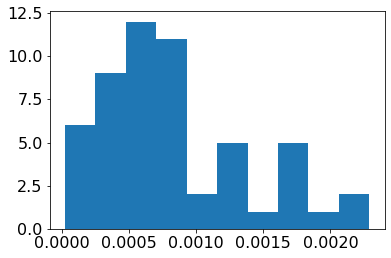

In [190]:
plt.hist(np.max(np.abs(y0s_ - y1s_), 1));

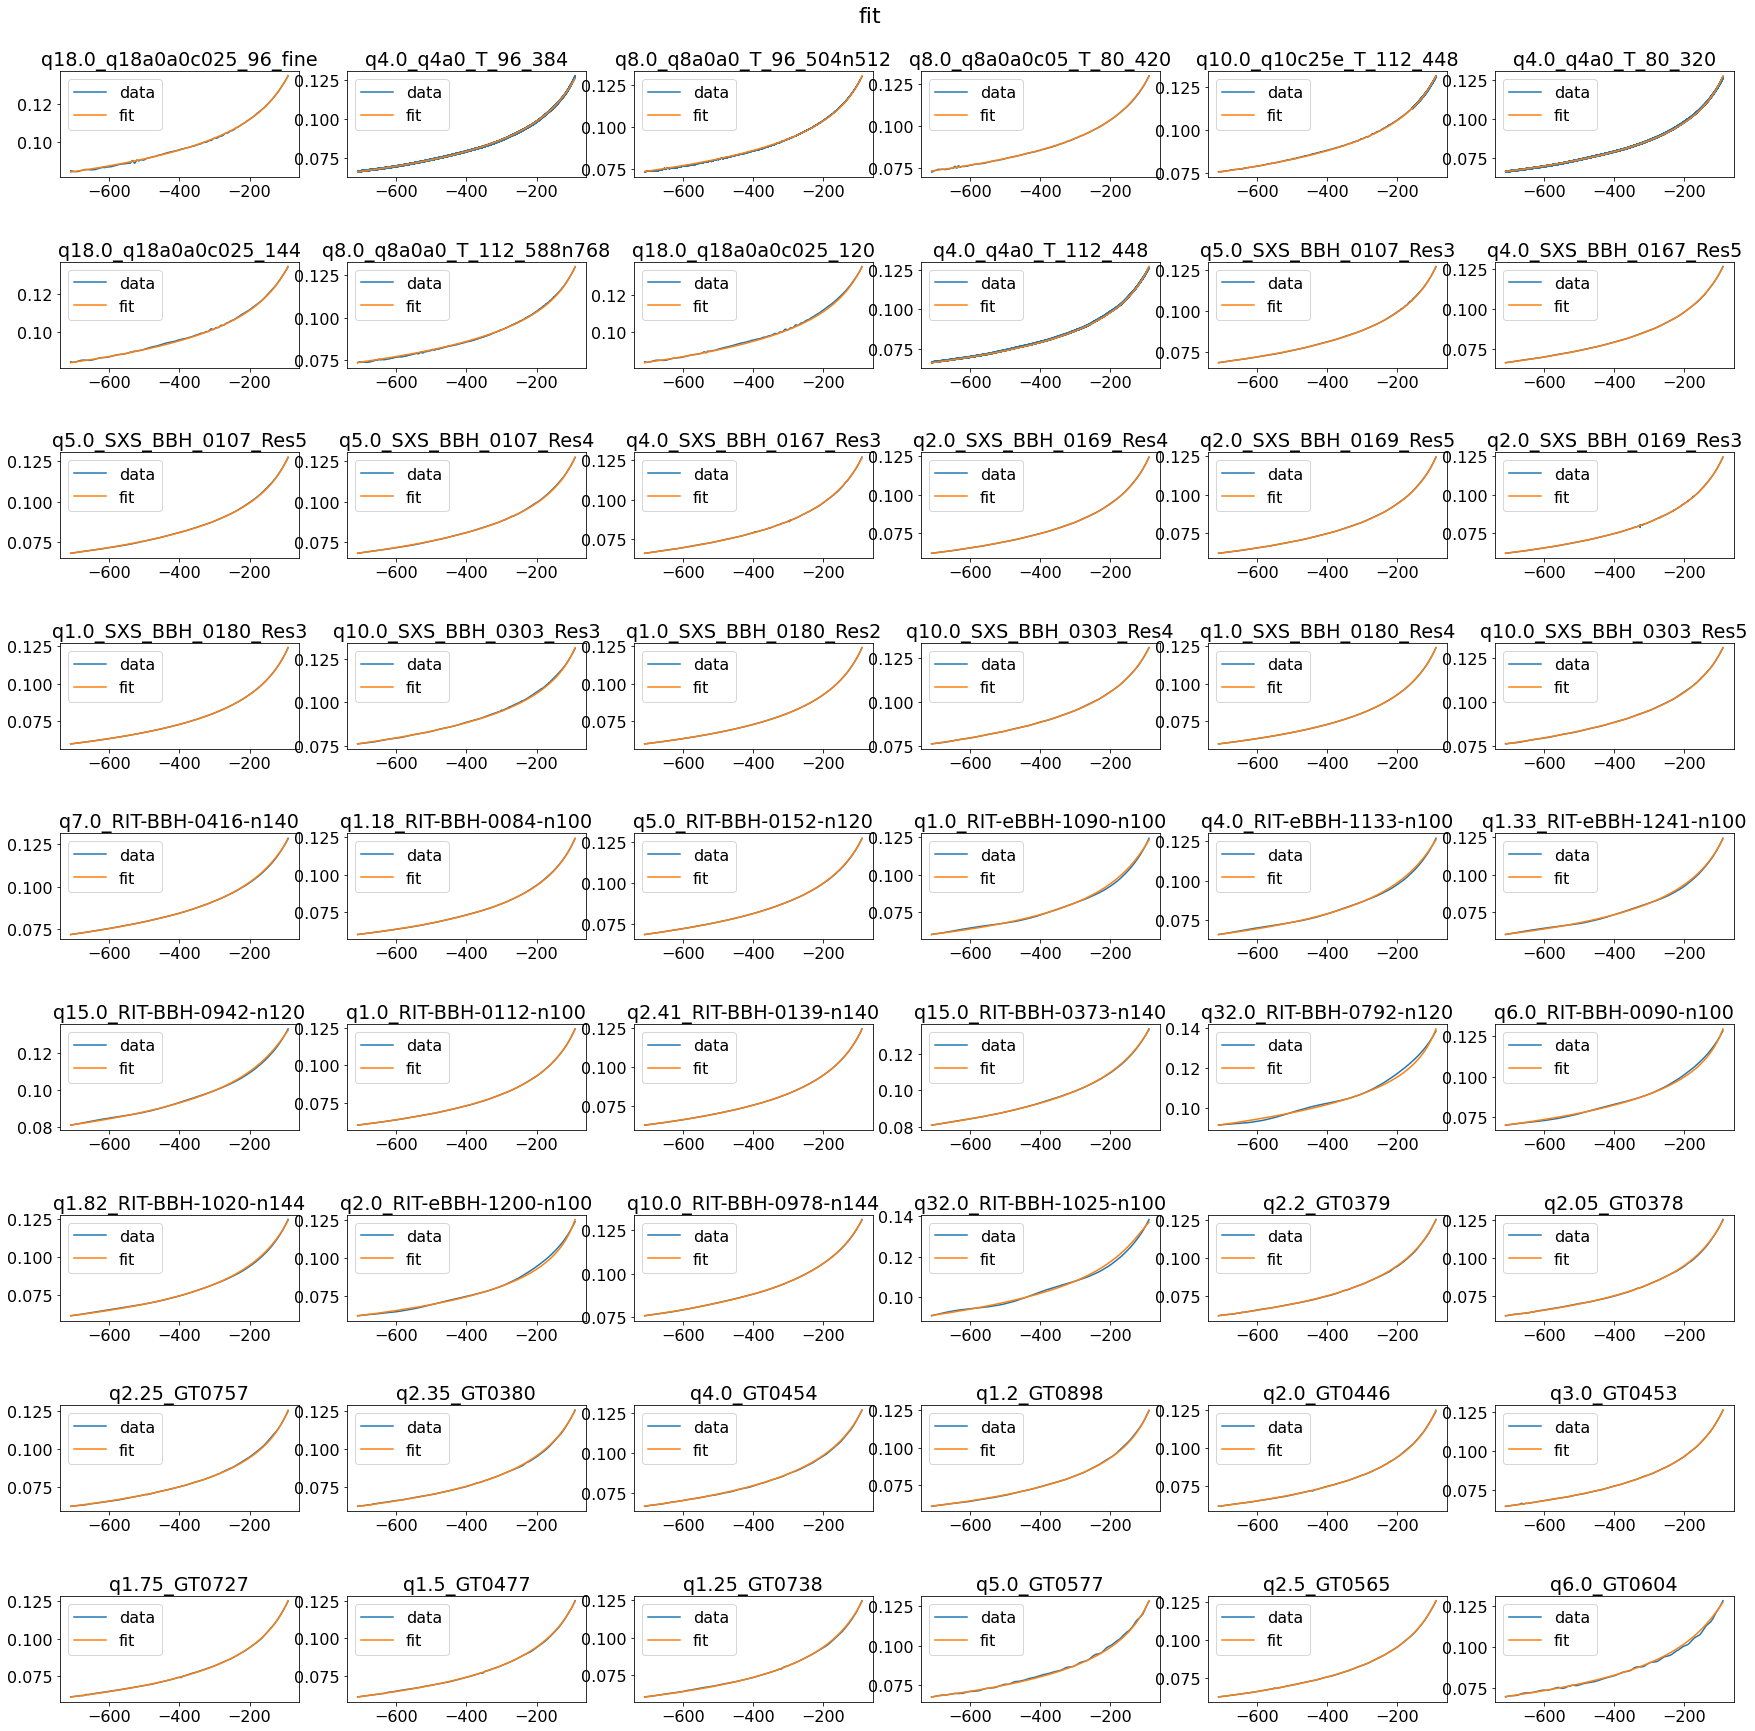

In [191]:
workflow_utils.plot_grid(xs=wcfs[0].x, ys=np.array([y0s_, y1s_]), ncols=6, figsize=(30, 30), titles=titles_, label=['data','fit'], suptitle="fit")

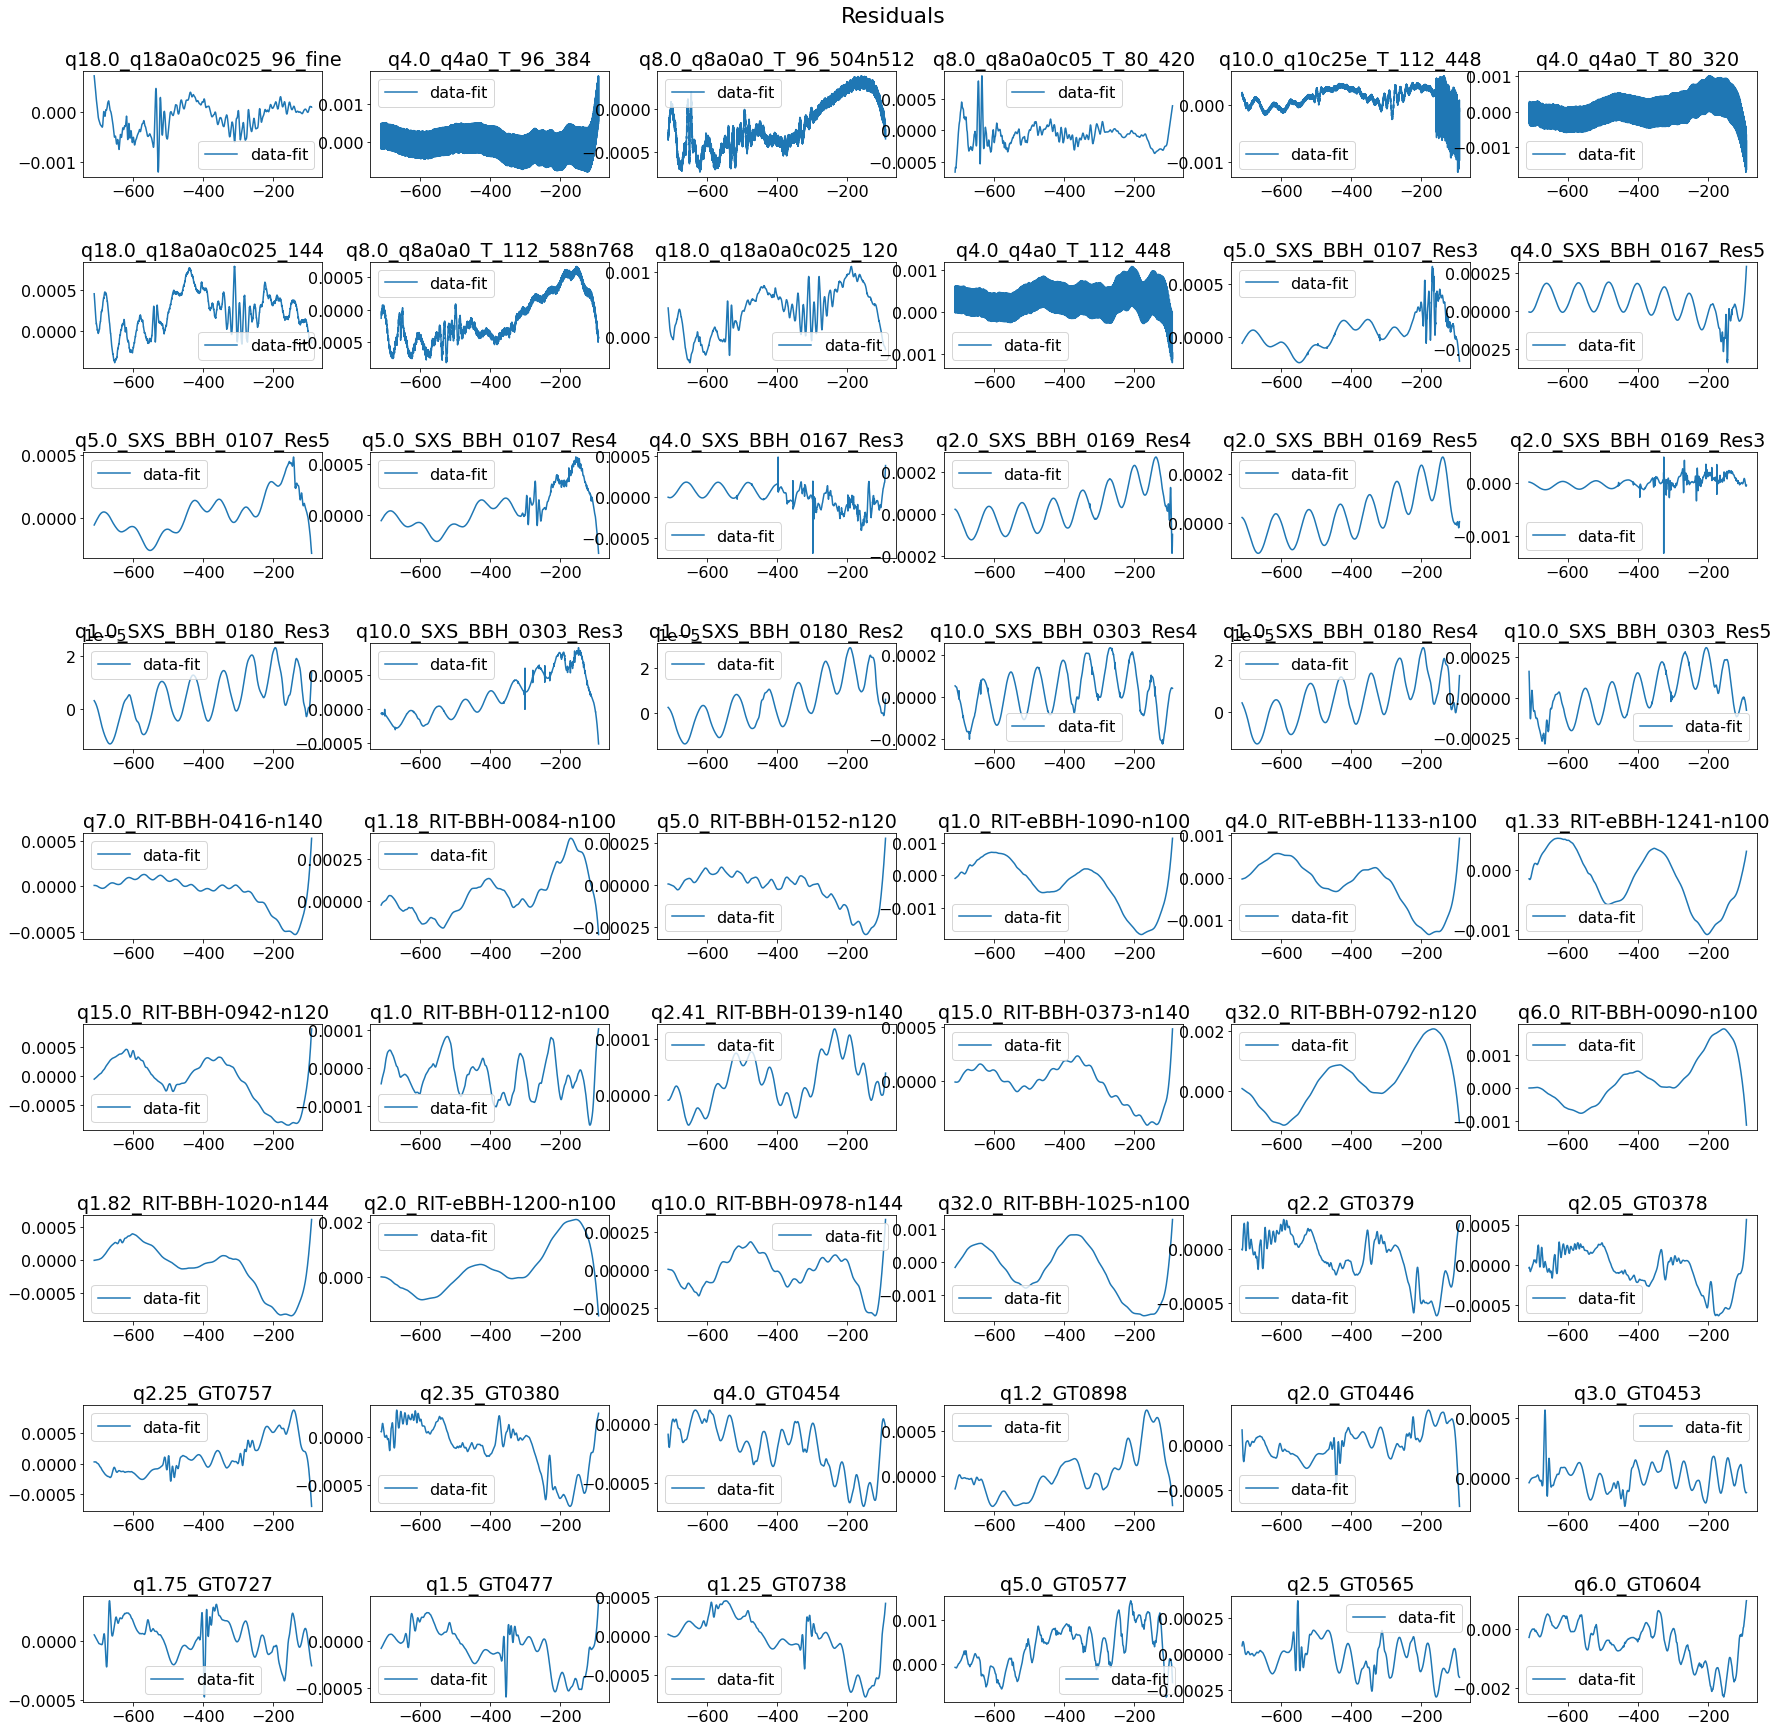

In [192]:
workflow_utils.plot_grid(xs=wcfs[0].x, ys=np.array([y0s_ - y1s_]), ncols=6, figsize=(30, 30), titles=titles_, label=['data-fit'], suptitle="Residuals")